### Make the Baseline

In [411]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
sns.set(color_codes=True)
from funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [306]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

### Import data exported from WellProcessing.ipynb

In [307]:
importSoquel = True
if importSoquel:
    df =  pd.read_pickle(lasdir.joinpath('allMWs_SC'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_SC_ind'))
else:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))

df2 =update_df2(df)
MPWSPnames = df2.loc[df2.FRES.notnull(),'Well'].unique()
MWnames = df.index.levels[0].values

### EC -> TDS 

In [308]:
x=df.EC1f
y=df.TDS1
msk = np.logical_and(x.notnull(),y.notnull())
slope, intercept, r_value, p_value, std_err = stats.linregress(x[msk].values.astype('float'),y[msk].values.astype('float'))

print(slope,intercept)
def EC1f2TDS(EC1f,m= 0.6906 ,b=282.46918):
    #EC1f in uS/cm
    return EC1f * m + b
# df = df.assign(TDS_from_EC = df.EC1f * slope + intercept )

0.6906012907863847 282.46917534097884


In [309]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)

### Unbounded (simple LS) EC --> Bulk cond
#### Aquifer-by-aquifer

Dune_Sand 621 0.8411844264888086
180-Foot 1841 0.9181664850637914
400-Foot 590 0.594021626110944


<Figure size 432x288 with 0 Axes>

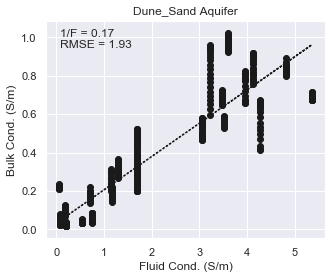

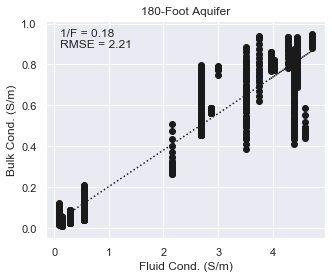

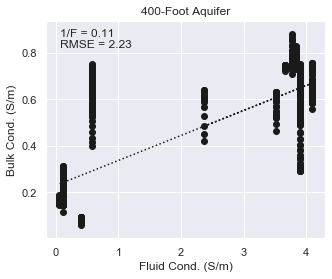

In [420]:
# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df = df.assign(logcild = np.log10(1/df.RILD))
df2=update_df2(df)
conditions = (df2.RILD.notnull(),
              df2.EC1f.notnull(),
             df2.Region=='Marina')
df_plot = df2.loc[nested_logicals(df2,conditions)]

slopes={}
for i,nam in enumerate(aq_groupnames):
#     x = df_plot[df_plot.AquiferGroup==nam].loc[:,'cond_est']
    x = df_plot[df_plot.AquiferGroup==nam].loc[:,'EC1f']/1e4
#     x = (df_plot[df_plot.AquiferGroup==nam].loc[:,'TDS1']).astype('float')
    y = 1/df_plot[df_plot.AquiferGroup==nam].loc[:,'RILD']
    
    c='k'
    if len(x)>0:
        f,ax,slope,intercept = x_y_regression(x,y,c,plotslp=True,slpname='1/F',returnslope=True,errtype='RMSE');
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        print(nam,len(x),r_value**2)
        ax.set_title(nam + ' Aquifer')
        plt.xlabel('Fluid Cond. (S/m)')
        plt.ylabel('Bulk Cond. (S/m)')
    #     cb = plt.colorbar()
    #     cb.set_label('Depth (ft)', rotation=90)
#         plt.savefig(figdir.joinpath('Archie_'+nam+'.png'.format(nam)),dpi=300,bbox_inches='tight')
        slopes[nam] = (slope,intercept)

### Assign predictions to df

In [421]:
breaks= [0,1000,3000,10000,100000]

F = np.zeros(len(df))
intercept_archie= np.zeros(len(df))

# x*slopes[nam][0]+slopes[nam][1]
for nam,slope in slopes.items():
    F[(df.AquiferGroup==nam).values]=slope[0]
    intercept_archie[(df.AquiferGroup==nam).values]=slope[1]
F[np.where(F==0)] = np.nan
intercept_archie[np.where(intercept_archie==0)] = np.nan

df = df.assign(F=F)
df = df.assign(intercept_archie=intercept_archie)
df = df.assign(cild_pred_archie= df.EC1f/1e4 * df.F + df.intercept_archie)
df = df.assign(logcild_pred_archie= np.log10(df.EC1f/1e4 * df.F + df.intercept_archie))
df = df.assign(EC1f_pred_archie =  1e4*(1/df.RILD - df.intercept_archie)/df.F )
df = df.assign(TDS_pred_archie = EC1f2TDS(df.EC1f_pred_archie))
FBS_pred_archie = update_FBS(df,'TDS_pred_archie',breaks=breaks,return_vec=True)
FBS_pred_archie[FBS_pred_archie==10] = 0
df = df.assign(FBS_pred_archie = FBS_pred_archie)

df2 = update_df2(df)

### CILD-->TDS
#### Aquifer-by-aquifer

Dune_Sand 621 32343.710111555924 766.8579502892153 0.8603937764226425
180-Foot 1841 35378.994033636605 206.5584857760623 0.9150873037800368
400-Foot 590 47114.02768121838 -4563.830841949428 0.8379134549220234


<Figure size 432x288 with 0 Axes>

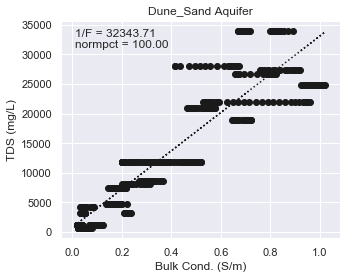

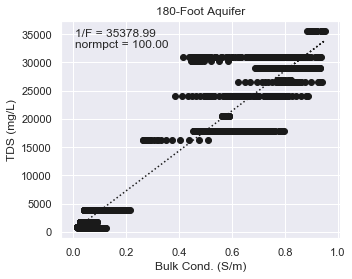

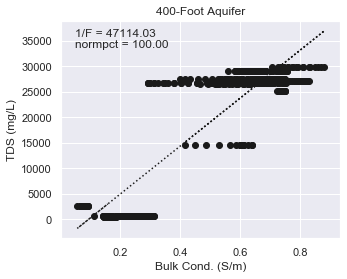

In [418]:
# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df = df.assign(logcild = np.log10(1/df.RILD))
df2=update_df2(df)
conditions = (df2.RILD.notnull(),
              df2.EC1f.notnull(),
             df2.Region=='Marina')
df_plot = df2.loc[nested_logicals(df2,conditions)]

slopes_TDS={}
for i,nam in enumerate(aq_groupnames):
#     x = df_plot[df_plot.AquiferGroup==nam].loc[:,'cond_est']
    x = (1./df_plot[df_plot.AquiferGroup==nam].loc[:,'RILD']).astype('float')
    y = (df_plot[df_plot.AquiferGroup==nam].loc[:,'TDS1']).astype('float')
    
    c='k'
    if len(x)>0:
        f,ax,slope,intercept = x_y_regression(x,y,c,plotslp=True,slpname='1/F',returnslope=True);
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        print(nam,len(x),slope,intercept,r_value**2)
        ax.set_title(nam + ' Aquifer')
        plt.xlabel('Bulk Cond. (S/m)')
        plt.ylabel('TDS (mg/L)')
    #     cb = plt.colorbar()
    #     cb.set_label('Depth (ft)', rotation=90)
#         plt.savefig(figdir.joinpath('Archie_'+nam+'.png'.format(nam)),dpi=300,bbox_inches='tight')
        slopes_TDS[nam] = (slope,intercept)

In [359]:
F = np.zeros(len(df))
intercept_archie= np.zeros(len(df))

# x*slopes[nam][0]+slopes[nam][1]
for nam,slope in slopes_TDS.items():
    F[(df.AquiferGroup==nam).values]=slope[0]
    intercept_archie[(df.AquiferGroup==nam).values]=slope[1]
F[np.where(F==0)] = np.nan
intercept_archie[np.where(intercept_archie==0)] = np.nan

df = df.assign(TDS_pred_archie_direct = F/df.RILD + intercept_archie)
FBS_pred_archie_direct = update_FBS(df,'TDS_pred_archie_direct',breaks=breaks,return_vec=True)
FBS_pred_archie_direct[FBS_pred_archie==10] = 0
df = df.assign(FBS_pred_archie_direct = FBS_pred_archie_direct)


In [377]:
df_plot = df2.loc[df2.Region=='Marina']
rmse(df_plot.TDS1,df_plot.TDS_pred_archie_all)

4296.827303349195

### Unbounded EC --> Bulk cond
#### All aquifers

All aquifers 3052 0.16368376961737988 0.06604291892789277 0.8346053810221075


Text(0, 0.5, 'TDS (mg/L)')

<Figure size 432x288 with 0 Axes>

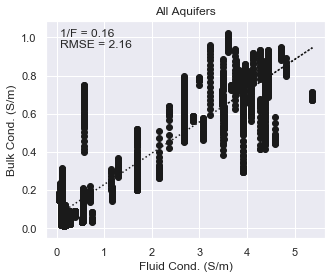

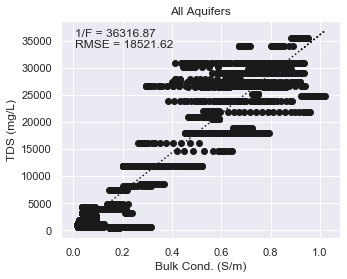

In [422]:
# df_plot =  df[np.logical_and(df.FRES.notnull(),df.RILD.notnull())] 
df2=update_df2(df)
conditions = (df2.RILD.notnull(),
              df2.EC1f.notnull(),
             df2.Region=='Marina')
df_plot = df2.loc[nested_logicals(df2,conditions)]
# dropind = df_plot.loc[np.logical_and(df_plot.Well.isin(('MW-9D','MW-8D')),df_plot.DEPT > 250)].index
# df_plot.drop(dropind,axis='index',inplace=True)
slopes={}

x = df_plot.loc[:,'EC1f']/1e4
# x = df_plot.loc[:,'TDS1'].astype('float')
y = 1/df_plot.loc[:,'RILD']

c='k'
f,ax,slope,intercept = x_y_regression(x,y,c,plotslp=True,slpname='1/F',returnslope=True,errtype='RMSE');
ax.set_title('All Aquifers')
plt.xlabel('Fluid Cond. (S/m)')
plt.ylabel('Bulk Cond. (S/m)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('All aquifers',len(x),slope,intercept,r_value**2)

    
    
x =  1/df_plot.loc[:,'RILD'] .astype('float')
y =df_plot.loc[:,'TDS1'].astype('float')
c='k'
f,ax,slope_TDS,intercept_TDS = x_y_regression(x,y,c,plotslp=True,slpname='1/F',returnslope=True,errtype='RMSE');
ax.set_title('All Aquifers')
plt.xlabel('Bulk Cond. (S/m)')
plt.ylabel('TDS (mg/L)')


(<Figure size 360x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13c56f710>)

<Figure size 432x288 with 0 Axes>

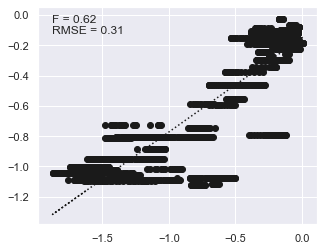

In [433]:
df2=update_df2(df)
df_plot = df2.loc[nested_logicals(df2,conditions)]
x_y_regression(df_plot.logcild.astype('float'),df_plot.logcild_pred_archie_all.astype('float'),'k',errtype='RMSE')

In [434]:
df = df.assign(FBS = update_FBS(df,'TDS1',breaks=breaks,return_vec=True))
df = df.assign(cild_pred_archie_all= df.EC1f/1e4 * slope + intercept)
df = df.assign(logcild_pred_archie_all= np.log10(df.EC1f/1e4 * slope + intercept))
# df = df.assign(EC1f_pred_archie_all =  1e4*(1/df.RILD*slope_cond + intercept_cond))
df = df.assign(TDS_pred_archie_all = 1/df.RILD * slope_TDS + intercept_TDS)
FBS_pred_archie_all = update_FBS(df,'TDS_pred_archie_all',breaks=breaks,return_vec=True)
# FBS_pred_archie_all[FBS_pred_archie_all==10] = 0
df = df.assign(FBS_pred_archie_all = FBS_pred_archie_all)
df2 = update_df2(df)

df.to_pickle(lasdir.joinpath('allMWs_SC'))

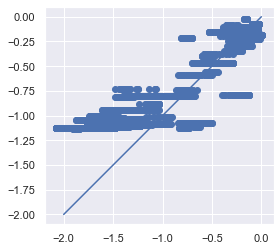

In [329]:
# plt.scatter(df.logcild_pred_archie,df.logcild_pred_archie_all)
plt.scatter(df.logcild,df.logcild_pred_archie_all)
plt.plot((-2,0),(-2,0))
plt.gca().set_aspect('equal')

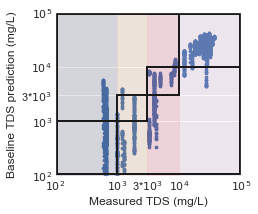

In [300]:
from matplotlib.patches import Rectangle
f,ax= plt.subplots(1,figsize=(3.33,3))
plt.ylabel('Baseline TDS prediction (mg/L)')
plt.xlabel('Measured TDS (mg/L)')
plt.xscale('log')
plt.xlim(100,100000)
plt.ylim(100,100000)
plt.yscale('log')
plt.fill([1,1,1000,1000],[1,1000000,1000000,1],  'k', alpha=0.1, edgecolor='r' )
plt.fill([1000,1000,3000,3000], [1,1000000,1000000,1], 'orange', alpha=0.1, edgecolor='r',label='TDS' )
plt.fill([3000,3000,10000,10000],[1,1000000,1000000,1],  'red', alpha=0.1, edgecolor='r',label='TDS' )
plt.fill([10000,10000,1000000,1000000],[1,1000000,1000000,1],  'pink', alpha=0.1, edgecolor='r',label='TDS' )
plt.scatter(df.TDS1,df.TDS_pred_archie,s=7.5,c='b')

rects =[]
rects.append(Rectangle((107,107),1000-107,1000-107,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((1000,1000),2000,2000,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((3000,3000),7000,7000,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((10000,10000),100000-15000,100000-15000,fill=False,edgecolor='k',linewidth=2))
rects.append(Rectangle((107,107),100000-5000,100000-5000,fill=False,edgecolor='k',linewidth=2))

for r in rects:
    ax.add_patch(r)
    
ticks = [100,1000,3000,10000,100000]
plt.xticks(ticks=ticks,labels=['$10^2$','$10^3$','3*$10^3$','$10^4$','$10^5$'],rotation=0)
plt.yticks(ticks=ticks,labels=['$10^2$','$10^3$','3*$10^3$','$10^4$','$10^5$'])

# plt.xticks(ticks=ticks,labels=ticks)
# plt.yticks(ticks=ticks,labels=ticks)

ax.tick_params('both', length=0, width=5, which='both',color='k')
plt.savefig(figdir.joinpath('Baseline_FBS_Prediction.png'),dpi=300,bbox_inches='tight')

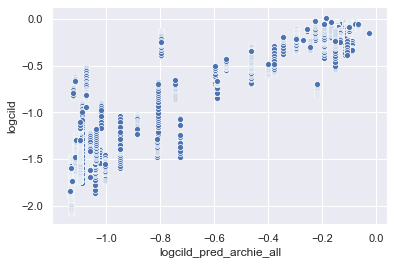

In [270]:
sns.scatterplot(x='logcild_pred_archie_all',y='logcild',data=df)

<Figure size 432x288 with 0 Axes>

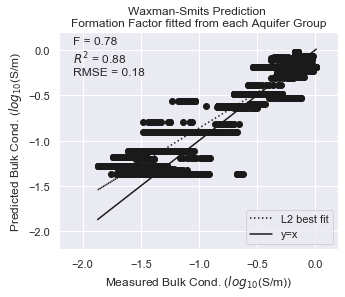

In [303]:
y_test = df.logcild
y_pred = df.logcild_pred_archie
msk=~np.isnan(y_pred)
y_test = y_test[msk]
y_pred = y_pred[msk]

# f,ax = plt.subplots(1,figsize=(3.3,4))
# ax.set_aspect('equal')
f,ax= x_y_regression(y_test,
                    y_pred,
                    'k',
                    plotone2one=True)
plt.xlim(-2.2,.2)
plt.ylim(-2.2,.2)

plt.xlabel('Measured Bulk Cond. ($log_{10}$(S/m))')
plt.ylabel('Predicted Bulk Cond. ($log_{10}$(S/m)')
plt.title('Waxman-Smits Prediction \nFormation Factor fitted from each Aquifer Group')
plt.legend(loc='lower right')
# plt.savefig(figdir.joinpath('WS_pred_logcild.png'),dpi=300,bbox_inches='tight')
plt.show()